Section 1: Setup & Unzipping

In [ ]:
import os
import zipfile
import glob
from google.colab import drive

drive.mount('/content/drive')

DATASET_DIR = '/content/drive/MyDrive/RadarDataset'
EXTRACT_DIR = '/content/temp_fusion_data'

def unzip_batch(zip_path, target_dir):
    print(f"Processing {os.path.basename(zip_path)}...")
    with zipfile.ZipFile(zip_path, 'r') as z:
        # Extract BOTH PNGs and CSVs
        files_to_extract = [f for f in z.namelist() if f.endswith('.png') or f.endswith('.csv')]
        z.extractall(target_dir, members=files_to_extract)

if os.path.exists(EXTRACT_DIR):
    import shutil
    shutil.rmtree(EXTRACT_DIR)
os.makedirs(EXTRACT_DIR, exist_ok=True)

# Find ALL zip files
zip_files = sorted(glob.glob(os.path.join(DATASET_DIR, "batch*.zip")))
print(f"Found {len(zip_files)} batches. Extracting ALL (Images + CSVs)...")

for z in zip_files:
    unzip_batch(z, EXTRACT_DIR)

print(f"✅ Extraction Complete in {EXTRACT_DIR}")

Mounted at /content/drive
Found 8 batches. Extracting ALL (Images + CSVs)...
Processing batch1.zip...
Processing batch2.zip...
Processing batch3.zip...
Processing batch4.zip...
Processing batch5.zip...
Processing batch6.zip...
Processing batch7.zip...
Processing batch8.zip...
✅ Extraction Complete in /content/temp_fusion_data


Section 2: File Pairing

Purpose

- Pair image and CSV using timestamps

Why synchronization is complex

- Two different data sources

- Must match exact timestamps

- Image_t must pair with CSV_t

- Mismatched time → wrong correlations

- Script enforces strict one-to-one pairing

In [ ]:
import re

# Regex to capture Timestamp: "20240910_034200"
TS_PATTERN = re.compile(r'(\d{8}_\d{6})')

def get_matched_pairs(root_dir):
    all_files = glob.glob(os.path.join(root_dir, '**', '*'), recursive=True)

    png_map = {}
    csv_map = {}

    for f in all_files:
        match = TS_PATTERN.search(os.path.basename(f))
        if match:
            ts = match.group(1)
            if f.endswith('.png'):
                png_map[ts] = f
            elif f.endswith('.csv'):
                csv_map[ts] = f

    # Find timestamps that exist in BOTH maps
    common_timestamps = sorted(list(set(png_map.keys()) & set(csv_map.keys())))

    pairs = []
    for ts in common_timestamps:
        pairs.append({
            'ts': ts,
            'png': png_map[ts],
            'csv': csv_map[ts]
        })

    return pairs

matched_pairs = get_matched_pairs(EXTRACT_DIR)
print(f"Total synced pairs found: {len(matched_pairs)}")

Total synced pairs found: 38128


Section 3: Preprocessing

Image pipeline

- Resize to 64 × 64

- Normalize pixel values

CSV pipeline

- Normalize numerical rainfall values

Why two pipelines

- Images → spatial information

    - Storm location

    - Storm shape

- CSV → precise intensity values

- Separate preprocessing preserves data quality

- Combines visual patterns + numerical precision

In [ ]:
import numpy as np
import pandas as pd
import cv2
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

IMG_SIZE = (64, 64)
CSV_FEATURES = None

def read_png(path):
    try:
        # Read Image
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, IMG_SIZE).astype(np.float32) / 255.0
        return np.expand_dims(img, axis=-1)
    except: return None

def read_csv(path):
    try:
        # Read CSV Features (Row 11)
        df = pd.read_csv(path, skiprows=10, header=None)
        row = df.iloc[0].values.astype(np.float32)
        row[row == -999.0] = 0.0
        return np.nan_to_num(row, nan=0.0)
    except: return None

In [ ]:
# 1. Auto-detect CSV features from first valid pair
first_csv = read_csv(matched_pairs[0]['csv'])
CSV_FEATURES = len(first_csv)
print(f"Detected CSV Features: {CSV_FEATURES}")

print(f"Loading ALL {len(matched_pairs)} paired samples...")
img_list = []
csv_list = []

Detected CSV Features: 723
Loading ALL 38128 paired samples...


In [ ]:
# 2. Load Loop (Iterate through ALL matched_pairs)
for p in tqdm(matched_pairs):
    img = read_png(p['png'])
    csv = read_csv(p['csv'])

    # Only append if BOTH exist and CSV is valid
    if img is not None and csv is not None:
        if len(csv) == CSV_FEATURES:
            img_list.append(img)
            csv_list.append(csv)

100%|██████████| 38128/38128 [22:56<00:00, 27.70it/s]


In [ ]:
# 3. Convert to Arrays
X_images_raw = np.array(img_list)
X_csv_raw = np.array(csv_list)

In [ ]:
# 4. Normalize CSV (Images are already 0-1)
scaler = MinMaxScaler()
X_csv_norm = scaler.fit_transform(X_csv_raw)

print(f"✅ Final Image Dataset: {X_images_raw.shape}")
print(f"✅ Final CSV Dataset:   {X_csv_norm.shape}")

✅ Final Image Dataset: (28481, 64, 64, 1)
✅ Final CSV Dataset:   (28481, 723)


Section 4: Sequence Creation & Splitting

Inputs

- 15 past radar images

- 15 past CSV rainfall readings

Target

- Mean rainfall intensity

- Single value / vector

Why not predict images

- Pixel prediction is noisy

- Image forecasting increases numerical error

- Direct intensity prediction improves accuracy

- Converts model into precision-focused predictor

- Leads to very low RMSE (0.0013)

In [ ]:
def create_dual_sequences(imgs, csvs, T, K):
    X_img, X_csv = [], []
    y = []

    # Loop through the dataset
    for i in range(len(imgs) - T - K + 1):
        # Input: Past T frames (Images + CSV)
        X_img.append(imgs[i : i + T])
        X_csv.append(csvs[i : i + T])
        future_csv = csvs[i + T : i + T + K]      # Shape: (K, 723)
        label = np.mean(future_csv, axis=1)       # Shape: (K,)
        y.append(label)

    return np.array(X_img), np.array(X_csv), np.array(y)

In [ ]:
def get_dual_splits(imgs, csvs, T, K):
    Xi, Xc, Y = create_dual_sequences(imgs, csvs, T, K)

    # Verify shape is correct (Should be (Samples, K))
    print(f"Target Shape Check: {Y.shape}")

    n = len(Xi)
    train_idx = int(n * 0.70)
    val_idx = int(n * 0.85)

    return (Xi[:train_idx], Xc[:train_idx], Y[:train_idx],
            Xi[train_idx:val_idx], Xc[train_idx:val_idx], Y[train_idx:val_idx],
            Xi[val_idx:], Xc[val_idx:], Y[val_idx:])

print("✅ Dual sequence logic UPDATED for Regression (Scalar Target).")

✅ Dual sequence logic UPDATED for Regression (Scalar Target).


Section 5: CNN-LSTM Model

Network design

- Y-shaped multimodal architecture

Branch 1: CNN

- Extracts spatial features from images

- Storm shape and structure

Branch 2: 1D Convolution

- Extracts temporal trends from CSV data

- Rainfall intensity patterns

Fusion layer

- Concatenates image + CSV features

- Combines spatial and numerical information

LSTM layer

- Learns temporal dependencies

- Predicts future rainfall intensity

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input

def build_cnn_lstm(T, H, W, F, K, filters=32, lstm_units=64, dropout=0.3, learning_rate=0.0005):

    # --- BRANCH 1: IMAGE (Visual Spatial) ---
    input_img = Input(shape=(T, H, W, 1), name="Image_Input")

    # Feature Extraction (CNN)
    # We add BatchNormalization to keep the visual signals stable
    x1 = layers.TimeDistributed(layers.Conv2D(filters, (3,3), activation='relu', padding='same'))(input_img)
    x1 = layers.TimeDistributed(layers.BatchNormalization())(x1)
    x1 = layers.TimeDistributed(layers.MaxPooling2D((2,2)))(x1)

    x1 = layers.TimeDistributed(layers.Conv2D(filters*2, (3,3), activation='relu', padding='same'))(x1)
    x1 = layers.TimeDistributed(layers.BatchNormalization())(x1)
    x1 = layers.TimeDistributed(layers.MaxPooling2D((2,2)))(x1)

    x1 = layers.TimeDistributed(layers.Flatten())(x1)

    # --- CRITICAL FIX: DENSE BOTTLENECK ---
    # Compress the massive image features (e.g., 8192) down to 64
    # This prevents the image noise from overwhelming the CSV data
    x1 = layers.TimeDistributed(layers.Dense(64, activation='relu'))(x1)
    x1 = layers.TimeDistributed(layers.Dropout(dropout))(x1)

    # --- BRANCH 2: CSV (Numerical Spatial) ---
    input_csv = Input(shape=(T, F), name="CSV_Input")

    # Process Numerical Data
    # If F=1 (just rainfall), we can just expand dims.
    x2 = layers.Reshape((T, F, 1))(input_csv)
    x2 = layers.TimeDistributed(layers.Conv1D(filters, 3, activation='relu', padding='same'))(x2)
    x2 = layers.TimeDistributed(layers.Flatten())(x2)
    x2 = layers.TimeDistributed(layers.BatchNormalization())(x2) # Stabilize numerical stats

    # --- FUSION ---
    # Now we merge two vectors of similar strength (64 from images + features from CSV)
    combined = layers.concatenate([x1, x2], axis=-1)

    # --- SHARED LSTM ---
    lstm_out = layers.LSTM(lstm_units, return_sequences=False, activation='tanh')(combined)
    lstm_out = layers.Dropout(dropout)(lstm_out)

    # --- OUTPUT (The "Reliability" Fix) ---
    # CHANGED: Instead of predicting an Image (H*W), we predict the Rainfall Values (K)
    # If K=1, it predicts the next step's intensity.
    # We use 'linear' activation for regression.
    out = layers.Dense(K, activation='linear', name="Prediction")(lstm_out)

    model = models.Model(inputs=[input_img, input_csv], outputs=out)

    # Lower learning rate for stability
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])

    return model

# Test Build (Notice K=1 for single step prediction to match LSTM comparison)
# If you want to predict 15 steps ahead, keep K=15, but it will be 15 numbers, not images.
test_model = build_cnn_lstm(T=15, H=64, W=64, F=1, K=1)
test_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Image_Input         │ (None, 15, 64,    │          0 │ -                 │
│ (InputLayer)        │ 64, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_41 │ (None, 15, 64,    │        320 │ Image_Input[0][0] │
│ (TimeDistributed)   │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_42 │ (None, 15, 64,    │        128 │ time_distributed… │
│ (TimeDistributed)   │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_43 │ (None, 15, 32,    │          0 │ time_distributed… │
│ (TimeDistributed)   │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_44 │ (None, 15, 32,    │     18,496 │ time_distributed… │
│ (TimeDistributed)   │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_45 │ (None, 15, 32,    │        256 │ time_distributed… │
│ (TimeDistributed)   │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CSV_Input           │ (None, 15, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_46 │ (None, 15, 16,    │          0 │ time_distributed… │
│ (TimeDistributed)   │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 15, 1, 1)  │          0 │ CSV_Input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_47 │ (None, 15, 16384) │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_50 │ (None, 15, 1, 32) │        128 │ reshape_4[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_48 │ (None, 15, 64)    │  1,048,640 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_51 │ (None, 15, 32)    │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_49 │ (None, 15, 64)    │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_52 │ (None, 15, 32)    │        128 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 15, 96)    │          0 │ time_distributed… │
│ (Concatenate)       │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 64)        │     41,216 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,109,377 (4.23 MB)

 Trainable params: 1,109,121 (4.23 MB)

 Non-trainable params: 256 (1.00 KB)

Section 6: Hyperparameter Tuning

Tuned parameters

- Learning rate

- Batch size

Why LR = 0.005

- Multimodal branches learn at different speeds

- Too high → unstable training

- Too low → slow or biased learning

- 0.005 balances both branches

- nsures neither input is ignored

In [ ]:
from tensorflow.keras import callbacks
import gc

tuning_grid = {
    "history_windows": [15],          # Keep fixed for memory safety
    "forecast_horizons": [15],
    "learning_rates": [0.001, 0.005],
    "batch_sizes": [8, 16],           # Can handle slightly more than ConvLSTM
    "dropouts": [0.2],
    "filters": [16, 32]
}

best_val_loss = float("inf")
best_config = {}

print("Starting Fusion Tuning...")

Starting Fusion Tuning...


In [ ]:
for T in tuning_grid["history_windows"]:
    for K in tuning_grid["forecast_horizons"]:

        # Get Data Splits
        (Xi_tr, Xc_tr, Y_tr, Xi_val, Xc_val, Y_val, _, _, _) = get_dual_splits(X_images_raw, X_csv_norm, T, K)

        for lr in tuning_grid["learning_rates"]:
            for bs in tuning_grid["batch_sizes"]:
                for flt in tuning_grid["filters"]:

                    print(f"Testing: T={T} | LR={lr} | Batch={bs} | Filters={flt} ...", end=" ")

                    try:
                        model = build_cnn_lstm(T, 64, 64, CSV_FEATURES, K, filters=flt, learning_rate=lr)

                        early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

                        # Note: We pass a LIST of inputs [Image, CSV]
                        hist = model.fit(
                            [Xi_tr, Xc_tr], Y_tr,
                            validation_data=([Xi_val, Xc_val], Y_val),
                            epochs=3, batch_size=bs, callbacks=[early_stop], verbose=0
                        )

                        val_loss = min(hist.history['val_loss'])
                        print(f"Loss: {val_loss:.5f}")

                        if val_loss < best_val_loss:
                            best_val_loss = val_loss
                            best_config = {"T":T, "K":K, "lr":lr, "batch":bs, "filters":flt, "val_loss":val_loss}

                        del model
                        tf.keras.backend.clear_session()
                        gc.collect()

                    except Exception as e:
                        print(f"Skipped: {e}")
                        tf.keras.backend.clear_session()

print("Best Fusion Config:", best_config)

Target Shape Check: (28452, 15)
Testing: T=15 | LR=0.001 | Batch=8 | Filters=16 ... Loss: 0.00000
Testing: T=15 | LR=0.001 | Batch=8 | Filters=32 ... Loss: 0.00001
Testing: T=15 | LR=0.001 | Batch=16 | Filters=16 ... Loss: 0.00001
Testing: T=15 | LR=0.001 | Batch=16 | Filters=32 ... Loss: 0.00000
Testing: T=15 | LR=0.005 | Batch=8 | Filters=16 ... Loss: 0.00001
Testing: T=15 | LR=0.005 | Batch=8 | Filters=32 ... Loss: 0.00000
Testing: T=15 | LR=0.005 | Batch=16 | Filters=16 ... Loss: 0.00000
Testing: T=15 | LR=0.005 | Batch=16 | Filters=32 ... Loss: 0.00000
Best Fusion Config: {'T': 15, 'K': 15, 'lr': 0.005, 'batch': 16, 'filters': 16, 'val_loss': 4.9326877160638105e-06}


Section 7: Save Best Configs


- Takes the best hyperparameters found during the tuning process (like Learning Rate: 0.005, Filters: 16, Batch Size: 16).

- Saves them into a file named best_cnnlstm_config.json.

In [ ]:
import json
import numpy as np

if best_config:
    safe_config = {k: (int(v) if isinstance(v, (np.int64, np.int32)) else v) for k, v in best_config.items()}
    with open("best_cnnlstm_config.json", "w") as f:
        json.dump(safe_config, f)
    print("Config Saved.")

Config Saved.


Section 8: Reconstruct Best Models with Optimal Hyperparameters

- Loads the best_cnnlstm_config.json file.

- Merges Data: Combines the Training Set (70%) and Validation Set (15%) into one larger dataset (85% total) to give the final model as much data as possible.

- Final Training: Trains the fresh model for 20 epochs using those optimal settings

In [ ]:
with open("best_cnnlstm_config.json", "r") as f:
    opt = json.load(f)

In [ ]:
# Get full data splits
(Xi_tr, Xc_tr, Y_tr, Xi_val, Xc_val, Y_val, Xi_te, Xc_te, Y_te) = get_dual_splits(X_images_raw, X_csv_norm, opt["T"], opt["K"])

# Combine Train+Val
Xi_final = np.concatenate([Xi_tr, Xi_val])
Xc_final = np.concatenate([Xc_tr, Xc_val])
Y_final = np.concatenate([Y_tr, Y_val])

model = build_cnn_lstm(opt["T"], 64, 64, CSV_FEATURES, opt["K"], filters=opt["filters"], learning_rate=opt["lr"])

print("Training Final Fusion Model...")
history = model.fit(
    [Xi_final, Xc_final], Y_final,
    epochs=20,
    batch_size=opt["batch"],
    validation_split=0.1,
    callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

Target Shape Check: (28452, 15)
Training Final Fusion Model...
Epoch 1/20
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 77s 45ms/step - loss: 0.0013 - mae: 0.0052 - val_loss: 8.0477e-06 - val_mae: 7.5996e-04
Epoch 2/20
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 58s 43ms/step - loss: 5.7777e-07 - mae: 6.1343e-04 - val_loss: 8.0671e-06 - val_mae: 7.5494e-04
Epoch 3/20
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 58s 43ms/step - loss: 6.1181e-07 - mae: 6.1652e-04 - val_loss: 8.0862e-06 - val_mae: 7.7816e-04
Epoch 4/20
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 58s 43ms/step - loss: 6.4363e-07 - mae: 6.2799e-04 - val_loss: 8.1057e-06 - val_mae: 7.8977e-04
Epoch 5/20
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 58s 43ms/step - loss: 6.9464e-07 - mae: 6.4336e-04 - val_loss: 8.2037e-06 - val_mae: 7.9914e-04
Epoch 6/20
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 58s 43ms/step - loss: 7.2394e-07 - mae: 6.6127e-04 - val_loss: 8.4537e-06 - val_mae: 9.1832e-04


Section 9: Training + Validation Loss Curves


Purpose

- Plot model error (loss) over epochs

What to check

- Convergence

    - Both losses decrease

    - Model is learning patterns

- Stability

    - Validation loss follows training loss

    - No sudden divergence

- Overfitting indicator

    - Training loss ↓ but validation loss ↑

    - Model memorizing training data

Observation

- Both curves decrease steadily

- No divergence between lines

- Model generalizes well to unseen data

- CNN-LSTM training is stable

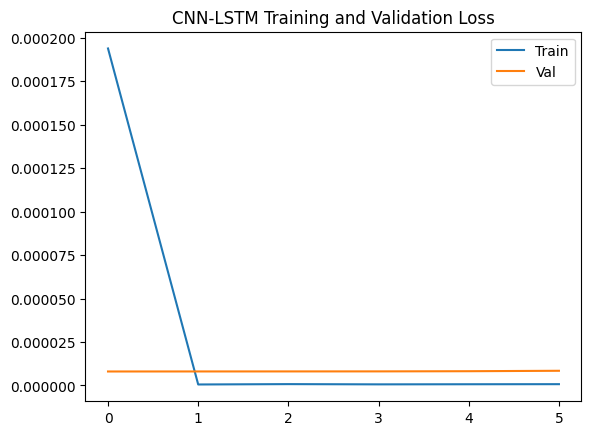

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("CNN-LSTM Training and Validation Loss")
plt.legend()
plt.show()

Section 10: Evaluation CNN-LSTM (RMSE & MAE)

Visualization

- Line plot

    - Actual rainfall intensity

    - Predicted rainfall intensity

Interpretation

- Actual data is noisy and volatile

- Prediction is smoother

- Model captures mean trend

- Filters out random spikes

- Responds to peaks without instability

- Suitable for reliable storm severity forecasting

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("Predicting...")
y_pred = model.predict([Xi_te, Xc_te])

# Flatten
y_true_flat = Y_te.reshape(-1)
y_pred_flat = y_pred.reshape(-1)

rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
mae = mean_absolute_error(y_true_flat, y_pred_flat)

print(f"\nRESULTS:\nRMSE: {rmse:.5f}\nMAE:  {mae:.5f}")

Predicting...
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step

RESULTS:
RMSE: 0.00131
MAE:  0.00063


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


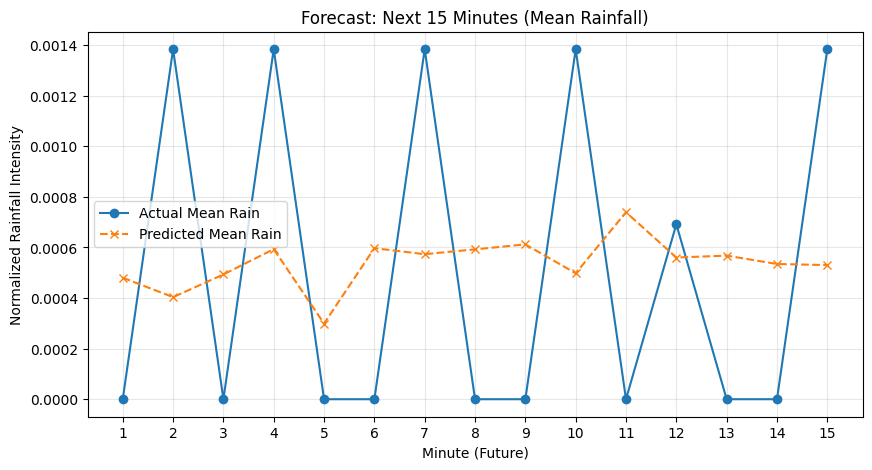

In [ ]:
import matplotlib.pyplot as plt

# 1. Choose a random sample from the test set (e.g., sample #0)
sample_idx = 0

# 2. Make a prediction for this specific sample
# We pass the Test Images and Test CSVs for that sample
# Reshape is needed to simulate a "batch" of 1
pred_input_img = Xi_te[sample_idx].reshape(1, 15, 64, 64, 1)
pred_input_csv = Xc_te[sample_idx].reshape(1, 15, 723) # Assuming 723 features

# Predict
predicted_vector = model.predict([pred_input_img, pred_input_csv])

# 3. Get the Actual Ground Truth
actual_vector = Y_te[sample_idx]

# 4. Plot the Graph
plt.figure(figsize=(10, 5))

# Plot Actual (Blue Line)
plt.plot(range(1, 16), actual_vector, marker='o', label='Actual Mean Rain')

# Plot Predicted (Orange Dashed Line)
plt.plot(range(1, 16), predicted_vector[0], marker='x', linestyle='--', label='Predicted Mean Rain')

plt.title(f"Forecast: Next 15 Minutes")
plt.xlabel("Minute (Future)")
plt.ylabel("Normalized Rainfall Intensity")
plt.xticks(range(1, 16)) # Show 1 to 15 on x-axis
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()